# ANOVA

This chapter is adapted from Danielle Navarro's excellent Learning Statistics with R book and adapted for Python by Todd Gureckis (2020) and Shannon Tubridy (2022)


### Goals for this notebook


- ANOVA in Python
    - plotting means and distributions of a numeric outcome variable within categorical groupings

    - one-way ANOVA (a single categorical independent or grouping variable with more than two levels and a numeric outcome variable)
    
        - example: Do assessment scores vary across four different NYC elementary schools?
        - example: Does the way people perceive others vary based on whether the rater is primed by reading stories with negative vs positive vs neutral content?
    - two- or more way ANOVA (multiple categorical indepedendent or grouping variables and a single numeric outcome variable)
        - example: 
    - repeated measures ANOVA (observations across levels of the independent variables are within person or entity)
        - example: Do individual people's working memory capacities vary across morning, noon, and night?



#### Data files used in this notebook

- Brightspace / Content / data / meditation.csv

In [1]:
# numpy for various numeric operations
import numpy.random as npr
import numpy as np

# pands for dataframes
import pandas as pd

# seaborn and matplotlib for plotting
import seaborn as sns
import matplotlib.pyplot as plt

# scipy, statsmodels, and pingouin for stats tests
import scipy.stats as stats
import statsmodels.formula.api as smf
import statsmodels.api as sm
import pingouin as pg



/opt/anaconda3/lib/python3.8/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.4.0, the latest is 0.5.1.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


## Introduction

In the regression notebook we constructed linear models that attempt to describe some outcome measurement (like mood) as a function of one or more predictor variables like quantity of sleep or amount of work.


ANOVA has a similar goal: try to account for variance in some outcome measure based on one or more predictor variables. 

The key difference for our current purposes is that we will _usually_ use regression when the predictor variable(s) are continuous or otherwise numerically meaningful, and ANOVA when the predictor variables are categorical or are factors.

## One way ANOVA


Common use case:

- One experimental manipulation with multiple levels, like different experimental groups measured on working memory capacity

- Analysis question: does the value of the outcome measure differ according to levels of the categorical independent variable?

### Simulating data

We'll simulate data from four groups of participants.

Random samples from a normal distribution using numpy:

```python
import numpy as np

mu = 0
sd = 1
n_samples = 100

np.random.normal(mu, sd, n_samples)
```

The numpy.random normal() function takes arguments:

- mu: mean of the distribution
- sd: standard deviation of the distribution
- n_samples: how many random samples you want

The result is an array of random number(s) drawn from a normal distribution with the mean and sd as indicated. The probability of any number being chosen is given by the normal distribution.

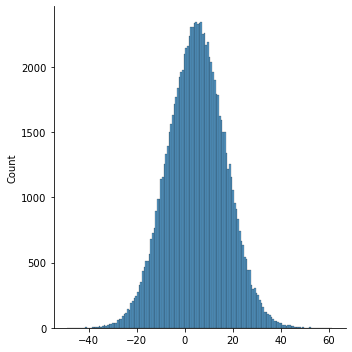

In [6]:
# get a sample of numbers from a normal distribution with mean 1 
# and sd 1 and histogram it
x = npr.normal(5, 12, 100000)

# seaborn displot for histograms can take a single input (the numbers)
# to histogram:
sns.displot(x)

### Making simulated participant data overview

We'll make fake data by getting data from some number of trials for each simulated participant in the "experiment". 

1. Each participant will be assigned to one experimental group
2. Participant data will come from random samples from a normal distribution using numpy
3. The experimental groups will differ in the mean of the Gaussian distribution we are sampling from
4. This will have the effect of giving us a difference, on average, between groups but also some variability

##### Experimental details

Four levels of experimental condition factor:
['A', 'B', 'C', 'control']

There will be 25 people per experimental condition

Each participant will do 50 trials



In [7]:
# make a list with the experimental conditions (exp_condition)
exp_conditions = ['A', 'B', 'C', 'control']

# set number of participants per group:
participants_per_group = 25

# each participant will do 50 trials:
n_trials = 50

# get the total number of participants in the experiment:
total_participants = participants_per_group * len(exp_conditions)

In [13]:
# make a list of participant numbers:
# for each i between 1 and number of participants, make a string
# that is e.g., `sub-1`, `sub-2`, etc
# and put the results of all that into a list called sub_nums

# empty list to append to:
sub_nums = []

# loop and make subject ids and store them in sub_nums list:
for i in range(1, total_participants+1):
    
    sub_nums.append(f'sub-{i}')
    
    
# sub_nums


In [12]:
# Alternative to for loop: LIST COMPREHENSION
sub_nums2 = [f'sub-{i}' for i in range(1,total_participants+1)]
sub_nums2

['sub-1',
 'sub-2',
 'sub-3',
 'sub-4',
 'sub-5',
 'sub-6',
 'sub-7',
 'sub-8',
 'sub-9',
 'sub-10',
 'sub-11',
 'sub-12',
 'sub-13',
 'sub-14',
 'sub-15',
 'sub-16',
 'sub-17',
 'sub-18',
 'sub-19',
 'sub-20',
 'sub-21',
 'sub-22',
 'sub-23',
 'sub-24',
 'sub-25',
 'sub-26',
 'sub-27',
 'sub-28',
 'sub-29',
 'sub-30',
 'sub-31',
 'sub-32',
 'sub-33',
 'sub-34',
 'sub-35',
 'sub-36',
 'sub-37',
 'sub-38',
 'sub-39',
 'sub-40',
 'sub-41',
 'sub-42',
 'sub-43',
 'sub-44',
 'sub-45',
 'sub-46',
 'sub-47',
 'sub-48',
 'sub-49',
 'sub-50',
 'sub-51',
 'sub-52',
 'sub-53',
 'sub-54',
 'sub-55',
 'sub-56',
 'sub-57',
 'sub-58',
 'sub-59',
 'sub-60',
 'sub-61',
 'sub-62',
 'sub-63',
 'sub-64',
 'sub-65',
 'sub-66',
 'sub-67',
 'sub-68',
 'sub-69',
 'sub-70',
 'sub-71',
 'sub-72',
 'sub-73',
 'sub-74',
 'sub-75',
 'sub-76',
 'sub-77',
 'sub-78',
 'sub-79',
 'sub-80',
 'sub-81',
 'sub-82',
 'sub-83',
 'sub-84',
 'sub-85',
 'sub-86',
 'sub-87',
 'sub-88',
 'sub-89',
 'sub-90',
 'sub-91',
 'sub-92

### Assign participants to experimental groups

Logic: 

1. Make a list of experimental conditions that has same length as number of participants and is split evenly between the four conditions in exp_conditions list (`cond_assignments`)

2. Use numpy.random.shuffle() function to randomize the order of experimental conditions in the `cond_assignments` list generated in step 1

3. During simulated data collection, participant N will be assigned to the experimental group indicated at position N in the `cond_assignments` list. That cond_assignment value will be used to (a) randomly sample data with different mean values based on the experimental condition for that person; (b) group the data by experimental condition for analysis

In [25]:
exp_conditions*2

['A', 'B', 'C', 'control', 'A', 'B', 'C', 'control']

In [27]:
# 1. Make a list of exp conditions that has same length as number of participants
# This can be achieved by taking our exp_condition list (length = 4) and multiplying
# it by the number of participants per group (25)
cond_assignments = exp_conditions*25


In [29]:
# 2. Use numpy.random.shuffle() to randomize
# the order of cond_assignments
# This is an inplace function so it will change our variable directly
np.random.shuffle(cond_assignments)
cond_assignments
                  


['A',
 'A',
 'control',
 'B',
 'C',
 'control',
 'C',
 'A',
 'C',
 'A',
 'control',
 'control',
 'B',
 'B',
 'A',
 'B',
 'B',
 'B',
 'C',
 'A',
 'A',
 'A',
 'B',
 'control',
 'B',
 'C',
 'A',
 'B',
 'C',
 'A',
 'C',
 'B',
 'control',
 'B',
 'B',
 'C',
 'C',
 'B',
 'C',
 'control',
 'control',
 'A',
 'B',
 'control',
 'B',
 'control',
 'control',
 'B',
 'B',
 'control',
 'A',
 'C',
 'A',
 'A',
 'A',
 'B',
 'C',
 'control',
 'B',
 'C',
 'control',
 'A',
 'A',
 'C',
 'C',
 'control',
 'C',
 'control',
 'C',
 'control',
 'C',
 'C',
 'B',
 'control',
 'C',
 'A',
 'C',
 'A',
 'B',
 'C',
 'A',
 'B',
 'control',
 'A',
 'C',
 'B',
 'control',
 'control',
 'C',
 'control',
 'C',
 'control',
 'B',
 'control',
 'A',
 'control',
 'A',
 'A',
 'B',
 'A']

In [30]:
# 3. For simulating data, make a dictionary that will give us the average response value
# for each of the experimental groups
# This will be the mean that we pass to numpy.random.normal(mean, sd, n_samples) 
# in order to get 'data' for each person
mean_dict = {'A': 10, 
             'B': 11, 
             'C': 10.5, 
             'control': 12}


In [32]:
mean_dict[cond_assignments[70]]

10.5

### For loops using enumerate

To generate the data we will loop over our list of participant ids and for each one we will get an experimental group assignment from the cond_assignments list.

We will use the enumerate() function in our for loop so that on each loop we get the participant id value as well as the index position of that value in the overall sub_nums list.

Here are some reminders about different ways to do for loops.


Sometimes we loop directly over an iterable object like a list:

```

some_list = ['person1', 'person2','person3']
for s in some_list:
    print(s)
```

The variable `s` will sequentially take on the values 'person1', then 'person2', etc and that value will be printed inside the loop.


And sometimes we loop over a range of numbers and then use that to do some indexing on a list or other object:

```
some_list = ['a','b','c']

for i in range(0,len(some_list)):
    print(some_list[i])
    
```

In this example, on each loop the variable `i` will take on one of the values 0 up to the length of the list minus 1, sequentially, and then that gets used inside the loop to access elements of `some_list` using bracket indexing.


An alternative to those is the enumerate() function which takes an iterable (like a list) as input and returns both the index positions _and_ the values. This can be quite useful for times when we both want everything from the list and want the current index position on each loop:

```
some_list = ['a','b','c']

for i, s in enumerate(some_list):
    print(f'i = {i}')
    print(f's = {s}')
```

In the enumerate example, `i` will take on the values 0 to the length of the list, one at a time, and `s` will take on the corresponding entry from some_list. On each iteration of the loop we have access to the current index position in `some_list` as well as the value at that position.

In [34]:
some_list = ['a','b','c']

for i, s in enumerate(some_list):
    print(f'i = {i}')
    print(f's = {s}')

i = 0
s = a
i = 1
s = b
i = 2
s = c


## make some simulated data

1) Loop over the participant list using enumerate.

2) For each participant, look up their experimental condition in the cond_assignments list using the current index value returned by enumerate.

3) Use that person's group assignment as a key for the `mean_dict` dictionary. The returned value is the average response value for people in that group.

4) Use numpy.random.normal() in combination with the mean value from step 3 to get random data for this person sampled from a random normal distribution with mean for that group

5) Compute the average of that person's responses and store the value

6) append the information from each participant to lists
- participant ID
- condition assignment (experimental group)
- average response

6) Make a dataframe summarizing the experiment


In [35]:
# remind ourselves about the experimental variables we already defined
%whos

Variable                 Type       Data/Info
---------------------------------------------
cond_assignments         list       n=100
exp_conditions           list       n=4
i                        int        2
l                        list       n=3
mean_dict                dict       n=4
n_trials                 int        50
np                       module     <module 'numpy' from '/op<...>kages/numpy/__init__.py'>
npr                      module     <module 'numpy.random' fr<...>umpy/random/__init__.py'>
participants_per_group   int        25
pd                       module     <module 'pandas' from '/o<...>ages/pandas/__init__.py'>
pg                       module     <module 'pingouin' from '<...>es/pingouin/__init__.py'>
plt                      module     <module 'matplotlib.pyplo<...>es/matplotlib/pyplot.py'>
s                        str        c
sm                       module     <module 'statsmodels.api'<...>ages/statsmodels/api.py'>
smf                      module     <mod

In [45]:
# set up some empty lists so we can append results as we 
# got through the loop
sub_id_list = []
sub_group_list = []
avg_response = []


# use enumerate to loop over people:
for i, sub_id in enumerate(sub_nums):
    
    # get this person's sub_id and condition assignment:
    sub_cond = cond_assignments[i]
    
    # get the mean response for this person based on their group assignment:
    sub_mean = mean_dict[sub_cond]
    
    # get n_trials worth of random numbers for this person using the mean
    # for their group as first input to np.random.normal():
    sub_data = np.random.normal(sub_mean, 1, n_trials)

    # get the average response for this person
    sub_mean = np.mean(sub_data)
    
    # append sub_id, experimental group, and average info to the empty lists
    # we initialized outside of the loop
    sub_id_list.append(sub_id)
    sub_group_list.append(sub_cond)
    avg_response.append(sub_mean)
    
    
# Loop is over, make a dataframe with columns exp_group, sub_id, and response:


In [48]:
df = pd.DataFrame({'exp_group': sub_group_list, 
                   'sub_id': sub_id_list,
                  'response': avg_response})

df

,exp_group,sub_id,response
0,A,sub-1,10.101441
1,A,sub-2,10.160637
2,control,sub-3,11.998812
3,B,sub-4,11.315585
4,C,sub-5,10.422409
...,...,...,...
95,control,sub-96,12.011642
96,A,sub-97,9.980977
97,A,sub-98,10.119998
98,B,sub-99,10.851367


Now we have 'data' from 100 people assigned to each of four experimental groups and we have an average score for each person in each group

### Visualizing means for each group


We can vizualize the mean response within each group using sns.catplot():

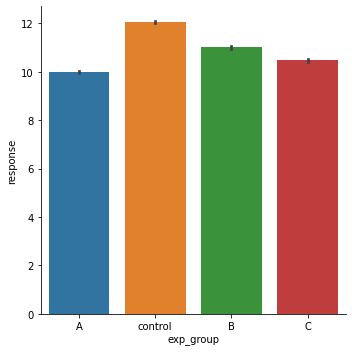

In [54]:
sns.catplot(x='exp_group', 
            y='response', 
            data=df,
           kind='bar')

### Running one-way ANOVA

The apparent effect of exp group on response can be tested statistically with a one way ANOVA.

There is a close link between ANOVA and linear regression. To start, we will set up our model using syntax we have already seen before in the regression notebook:

In [56]:
oneway_model = smf.ols(formula = 'response ~ C(exp_group)', data=df)
oneway_model = oneway_model.fit()

To this point we have done *exactly* the same thing as fitting a regression model with the execption that we put C() around our predictor variable. This is to ensure that it is treated as a *categorical* variable. 

To get an ANOVA table from this we use sm.stats.anova_lm() and input the fit model we've already estimated:

In [57]:
anova_table = sm.stats.anova_lm(oneway_model, typ=1)
anova_table




,df,sum_sq,mean_sq,F,PR(>F)
C(exp_group),3.0,57.888620,19.296207,890.030065,6.735491e-70
Residual,96.0,2.081318,0.021680,NaN,NaN


Looks like an ANOVA result. 

Notice also that the anova_lm() function can take a typ= argument in addition to taking the fit model itself. 

This corresponds to the type 1, type 2, and type 3 sum of squares versions of ANOVA. We won't discuss specifics of their application here, but will simply note that flexibility of the anova_lm() function.

Our resulting ANOVA table has the info we would need to interpret and write up our results. 

In this case there seems to be a main effect of experimental group, as indicated by the PR(>F) value (the p value) being much less than zero. 

We also have the F statistic itself, along with the degrees of freedom. The results object is a dataframe so we can access to individual values like this:



In [58]:
anova_table

,df,sum_sq,mean_sq,F,PR(>F)
C(exp_group),3.0,57.888620,19.296207,890.030065,6.735491e-70
Residual,96.0,2.081318,0.021680,NaN,NaN


In [62]:
anova_table['PR(>F)'][0]

6.73549108213841e-70

From there we can automatically generate a results string that is populated with the appropriate values:

In [65]:
df_bet = anova_table['df'][0], 2
df_within = anova_table['df'][1]

F = anova_table['F'][0]
p = anova_table['PR(>F)'][0]


print(f'F({df_bet}, {df_within}) = {np.round(F,2)}, p = {np.round(p,2)}')

F((3.0, 2), 96.0) = 890.03, p = 0.0


### Post-hoc pairwise comparisons

A significant one-way ANOVA results indicates that the exp group has an effect on response, but doesn't tell which groups are different from each other. 

For that we use post-hoc comparisons

There are a variety of ways to compute these comparisons. 

One common approach is to compute **Tukey's HSD** which will give us the significance of differences between each pairwise combination of groups in the data while maintaining Type I error expectation in the face of multiple comparisons.

There is a Tukey HSD function in the statsmodels library.

The function takes in an `endog=` argument which is the outcome variable, a `groups=` argument which is an array of factors in our ANOVA (in this case we have only one), and a desired experiment-wide false alarm rate (alpha).


```python
from statsmodels.stats.multicomp import pairwise_tukeyhsd
tukey_comparisons = pairwise_tukeyhsd(endog = array_of_outcome_values,
                          groups = array_of_group_labels,
                          alpha = overall false alarm rate)
```

The `array_of_outcome_values` and the `array_of_group_labels` should be of the same length, and each entry is lined up so that `array_of_group_labels` tells you what condition each value in `array_of_outcome_values` came from.


In [67]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
tukey_comparisons = pairwise_tukeyhsd(endog = df['response'],
                          groups = df['exp_group'],
                          alpha = .05)


tukey_comparisons.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
A,B,1.0109,0.001,0.902,1.1198,True
A,C,0.4871,0.001,0.3782,0.596,True
A,control,2.0504,0.001,1.9415,2.1593,True
B,C,-0.5238,0.001,-0.6327,-0.4149,True
B,control,1.0395,0.001,0.9306,1.1484,True
C,control,1.5633,0.001,1.4544,1.6722,True


Each row of the output from the Tukey's test shows us the two groups being compared (group1 and group2), the average difference between them, the adjusted p value (accounting for multiple comparisons), and the confidence intervals on the difference score.

In our simulated data, each group was different from every other group, but in real data this isn't necessarily the case, even if there is a main effect of group.

### Two (or more) way ANOVA

Many experiments will include a crossing of multiple experimental conditions or factors. 

For example:

People are assigned to one of four participant groups (factor 1) and each person does either an easy or hard version of the task (factor 2). The outcome measure is the score on each task.

- Does the experimental group have an effect on the responses?
- Does the type of task (easy/hard) have an effect on the responses?
- Is there an interaction of group and type of task performance?


We'll generate some data to include a second factor that we can examine.

In [68]:
# this cell generates data in a two-way design with an interaction
exp_conditions = ['A', 'B', 'C', 'control']


trial_types = ['easy', 'hard']


n_trials = 50

participants_per_group = 25
total_participants = len(exp_conditions) * participants_per_group

# make a list of participant numbers using list comprehension
sub_nums = [f'sub-{i}' for i in range(1, total_participants+1)]

# loop over the experimental groups
# for each one, generate 25 participants of random data
# we can get 50 trials of data for each person and then
# for each participant, get their average response to be used
# in our ANOVA

# set up some empty lists so we can append results as we 
# got through the loop
exp_group = []
avg_response = []
t_types = []
subs = []

# use enumerate(). This will give us the index
# position of each entry in exp_groups (stored in i)
# as well as the group name itself (stored in 'group')
for i, group in enumerate(exp_conditions):

    # simulate individual participants:
    for s in range(participants_per_group):
        
        for it, tr in enumerate(trial_types):
        
        
            # get n_trials worth of data for this 'person'
            # we will use the index position taken from enumerate
            # as the input for the mean value in 
            # npr.normal(mu, sd, n_samples)
            
            # for each group except 'control', increase the mean by one
            # if it's the hard condition
            if group != 'control':
                s_trials = npr.normal(i+it, 1, n_trials)
            else:
                s_trials = npr.normal(i, 1, n_trials)

            # get the average of this person's trial data
            # and store it in the avg_response list
            avg_response.append(np.mean(s_trials))

            # keep track of this person's experimental group
            exp_group.append(group)
            
            # track the trial type
            t_types.append(tr)
            
            # the subject number
            subs.append(f'sub-{s}')
    
# make a dataframe that has subject id, avg response, and group
two_way_df = pd.DataFrame({'id': subs,
                          'response': avg_response,
                          'exp_group': exp_group,
                          'trial_type': t_types})


two_way_df


,id,response,exp_group,trial_type
0,sub-0,0.013627,A,easy
1,sub-0,0.948690,A,hard
2,sub-1,0.101971,A,easy
3,sub-1,1.035964,A,hard
4,sub-2,0.077149,A,easy
...,...,...,...,...
195,sub-22,2.926538,control,hard
196,sub-23,2.725375,control,easy
197,sub-23,2.914230,control,hard
198,sub-24,2.789412,control,easy


First let's plot the data using sns.catplot() using the hue= argument so that we can account for two grouping or categorical variables.

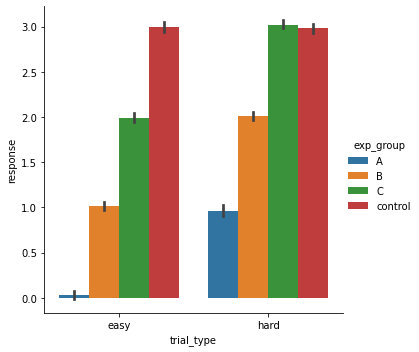

In [73]:
sns.catplot(hue='exp_group',
            x='trial_type',
            y='response', 
            data = two_way_df,
           kind='bar')

### The catplot() point plot

The `kind='point` variant of catplot() produces figures of the type often presented with ANOVAs.

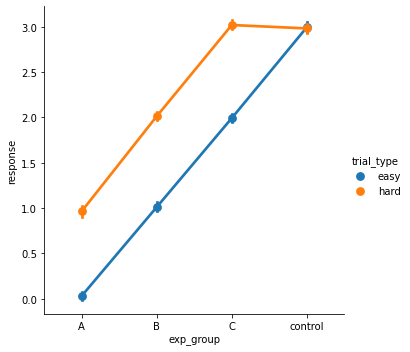

In [75]:
sns.catplot(x='exp_group',
            hue='trial_type',
            y='response', 
            data = two_way_df,
           kind='point')

In these data it looks like the response varies based on the group and there is also a difference based on trial type (hard trials usually associated with inreased response value compared to easy). 

Lastly, it looks like there might be an interaction between exp group and trial type: the effect of trial type does not seem to be the same in the control group compared to groups A, B, and C.

Now we can do a two-way ANOVA to check all this.

## Running two-way ANOVA in Python

Fortunately, running a two (or more) way ANOVA is basically the same as a one-way with a slightly more complicated `formula=` argument:

```python
model = smf.ols(formula = 'outcome ~ C(factor1) + C(factor2) + C(factor1):C(factor2)', 
                       data=two_way_df)
model_fit = model.fit()

anova_table = sm.stats.anova_lm(twoway_model, typ=1)
```


In [77]:
# run two way ANOVA on outcome 'response' for factors exp_group and trial_type
model = smf.ols(formula = 'response ~ C(exp_group) + C(trial_type) + C(exp_group):C(trial_type)', 
                       data=two_way_df)

model_fit = model.fit()

anova_table = sm.stats.anova_lm(model_fit, typ=1)

anova_table

,df,sum_sq,mean_sq,F,PR(>F)
C(exp_group),3.0,183.357215,61.119072,3624.167338,1.049489e-168
C(trial_type),1.0,27.205408,27.205408,1613.194536,2.261984e-95
C(exp_group):C(trial_type),3.0,9.444701,3.148234,186.680278,1.147565e-56
Residual,192.0,3.237947,0.016864,NaN,NaN


Take a look at our formula for the model:

>`'response ~ C(exp_group) + C(trial_type) + C(exp_group):C(trial_type)'`

What we've done is include our two categorial predictors (exp_group and trial_type), specifying them as categorical (C()), and then also asked the model to estimate the effect of the interaction between those groups using the `:` to join them.

For convenience one can also use the following syntax in order to get a full crossing (main effect and interaction) of the factors:

>`'response ~ C(exp_group)*C(trial_type)'`

In [78]:
# run two-way ANOVA with full crossing by C(factor1)*C(factor2)
# run two way ANOVA on outcome 'response' for factors exp_group and trial_type
model = smf.ols(formula = 'response ~ C(exp_group)*C(trial_type)', 
                       data=two_way_df)

model_fit = model.fit()

anova_table = sm.stats.anova_lm(model_fit, typ=1)

anova_table

,df,sum_sq,mean_sq,F,PR(>F)
C(exp_group),3.0,183.357215,61.119072,3624.167338,1.049489e-168
C(trial_type),1.0,27.205408,27.205408,1613.194536,2.261984e-95
C(exp_group):C(trial_type),3.0,9.444701,3.148234,186.680278,1.147565e-56
Residual,192.0,3.237947,0.016864,NaN,NaN


Once again we can use `anova_lm()` on our ols results to obtain the ANOVA table. 

Now we see a row for each factor, along with p values for the main effect, and the interaction row (C(exp_group):C(trial_type)).

In our case we have significant main effects as well as a significant interaction, as indicated by the small p value (PR(>F).

**NOTE**: Python is displaying our very small p values in scientific notation. So 1.29e-166 means take 1.29 and move the decimal 166 places to the left. This is a very small number.  

Perhaps a clearer example is that 5e-2 is .05:

In [79]:
p = 5e-2
p == .05

True

We will not spend much time talking about ANOVA follow-up analyses for interactions because it is not as straightforward as doing Tukey's test. 

Fundamenally what we want to do is understand the interaction. 

One approach is to plot the data like before and the interaction is often clear.

Another approach is to use the pingouin pg.pairwise_ttests() to get the pairwise comparison between all crossings of the factors,  focus on the rows that have a combined Contrast, and look for places where the significance varies across conditions.

The pg.pairwise_ttests() function takes in the dependent variable (dv=), the grouping factors (between=[]), the data, and an optional adjustment for multiple comparisons (padjust)

In [80]:
pg.pairwise_ttests(dv='response', 
                   between=['exp_group', 'trial_type'], 
                   data=two_way_df, 
                   padjust='bonferroni')


,Contrast,exp_group,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,hedges
0,exp_group,-,A,B,False,True,-10.018961,98.0,two-sided,1.100847e-16,6.605083e-16,bonferroni,3.727e+13,-1.988418
1,exp_group,-,A,C,False,True,-19.560493,98.0,two-sided,1.305369e-35,7.832214e-35,bonferroni,1.107e+32,-3.882083
2,exp_group,-,A,control,False,True,-34.536191,98.0,two-sided,1.150397e-56,6.902384e-56,bonferroni,6.247e+52,-6.854241
3,exp_group,-,B,C,False,True,-9.444597,98.0,two-sided,1.943496e-15,1.166098e-14,bonferroni,2.347e+12,-1.874426
4,exp_group,-,B,control,False,True,-19.492903,98.0,two-sided,1.710932e-35,1.026559e-34,bonferroni,8.485e+31,-3.868668
5,exp_group,-,C,control,False,True,-6.212139,98.0,two-sided,1.269756e-08,7.618537e-08,bonferroni,7.919e+05,-1.232895
6,trial_type,-,easy,hard,False,True,-5.241891,198.0,two-sided,4.058094e-07,NaN,NaN,3.199e+04,-0.738504
7,exp_group * trial_type,A,easy,hard,False,True,-22.908279,48.0,two-sided,1.718638e-27,6.874552e-27,bonferroni,9.259e+23,-6.377669
8,exp_group * trial_type,B,easy,hard,False,True,-30.187781,48.0,two-sided,7.122096e-33,2.848838e-32,bonferroni,1.641e+29,-8.404283
9,exp_group * trial_type,C,easy,hard,False,True,-29.276360,48.0,two-sided,2.880159e-32,1.152064e-31,bonferroni,4.196e+28,-8.150543


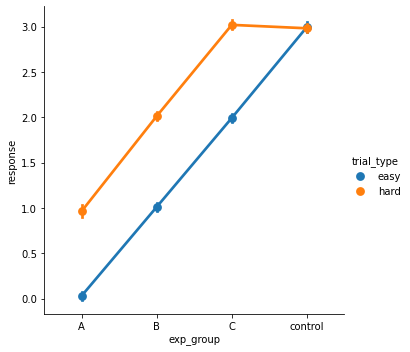

In [81]:
sns.catplot(x='exp_group',
            hue='trial_type',
            y='response', 
            data = two_way_df,
           kind='point')

The output gives us many t-test results, but we are interested in the interaction. In particular, we are interested in whether the effect of easy and hard trials is the same for each experimental group. The last four rows here show us those results: for groups A, B, and C, the test between easy and hard is significnat (p<.05), whereas for the control group that comparison is not significant. That is our interaction.

## Repeated measures ANOVA

When your experimental design has measurements from the same people in multiple conditions you are in the realm of repeated measures ANOVA.

A between participants ANOVA might measure the effect of performing some task under three different levels of distraction (low, medium, high), with different people assigned to each of the three distraction groups.

If each person performed the task under each of the three different levels of distraction we would want to run a repeated measures ANOVA. 

The primary reason for the difference has to do with how the variance is accounted for or partitioned in the different settings and you can find abundant discussion of the details in your stats notes or in any number of online sources. In this notebook we'll focus on the mechanics of running the analysis in Python.

### A mixed design repeated measures dataset

_(Thanks to Raphael Vallat for the example)_

As an example, we will ask whether meditation can improve school performance in primary school students.

The experimental design we'll use:

- students are split into a control group and a meditation group
    - meditation group: instructed to meditate for 20 minutes a day
    - control group: instructed not to change their daily routine
    - this is a **between-group factor**

- to assess whether meditation improves or worsens performance over time each student is assessed on performance at three time points during the year
    - august: time = 0
    - january: time = 6 months
    - june: time = 12 months
    - This is a **within-person factor**

Our data will have: the test scores (dependent variable), time of year (three levels; within participant), and meditation or control group (two levels; between participants). 

This is a "mixed design" because we have a mix of within (time of test) and between (meditation-yes, meditation-no) participants factors.

A simulated dataset with this structure is saved in meditation.csv

In [ ]:
# load meditation.csv into dataframe called df



In [ ]:
# look at data from one person using Boolean indexing on the 'Subject' column


We can check out the overall pattern of results visually using any number of seaborn plot types. 

Or take a look at the mean and std for each group combination using groupby:

### One-way Repeated measures ANOVA

First, let's just run a repeated measures ANOVA on one of our factors: Time. 

Each person was tested at three timepoints so looking at that factor gives us a pure within participant or repeated measures design.

In [ ]:
df.head()

### Use pinguoin library for easy access to repeated measures ANOVA:



```python
rm_reslts = pg.rm_anova(data=some_data_frame, 
                        dv='outcome_variable', 
                        within='factor1', 
                        subject='variable_linking_factor1_measurements')
```

- 'data' is where the data live
- 'dv' is the outcome variable, 
- 'within' is the predictor variable or IV 
- 'subject' is the column that links the different measurements together, telling pingouin which Time scores should be grouped together within participant ID



In [ ]:
# run within person repeated measures ANOVA


In [ ]:
# results object is a dataframe and individual values can be accessed:



In [ ]:
# post-hoc tests in a one-way repeated measures design can be achieved 
# by a series of pairwise paired t-tests with an appropriate multiple comparisons
# correction to the p-values

# we can use pingouin pairwise_ttest() function to do this

# dv is the dependent variable or outcome measure
# within is the within person factor(s)
# subject is a column that links within-person measurements of the within= variable(s)
# data is where the dv, within, and subject variables are located
# padjust is the method for p value adjustment for multiple comparisons

pg.pairwise_ttests(dv='Scores', 
                   within='Time', 
                   subject='Subject', 
                   data=df,
                   padjust='bonferroni')


### Running mixed design ANOVA

Using an ANOVA to test the effect of meditation (or none) on scores over time will require the use of mixed design ANOVA that enables us to account for both the between groups factor (meditation vs control) and the within person, or repeated measures, factor of time.

In [ ]:
df.head()

To specify such a model in pingouin we need to define the dependent variable, the within subject factor, the between subject factor, and the id that links across repeated measures. In our data this latter value is in the 'Subject' column and this is what is used to match the scores over time within person.


```python
aov = pg.mixed_anova(dv='outcome_variable',
                     within='within_subject_factor',
                     between='between subject factor',
                     subject='the column that links measuremets on the within factor',
                     data=place_where_all_the_data_live)
                     
    
```

In [ ]:
# check out the results

The results indicate a significant main effect of Group and Time as well as an interaction, but not which pairs of measurements differ from each other. Pingouin also provides a nice way to get all the pairwise tests using `pg.pairwise_ttests()`

In [ ]:
posthocs = pg.pairwise_ttests(dv='Scores', 
                              within='Time', 
                              between='Group',
                              subject='Subject', 
                              data=df)
posthocs

Of course, that's a lot of pairwise tests to run, so if we want to use a corrected p value we can add in the padju= argument to the pairwise_ttests() function.

In [ ]:
pg.pairwise_ttests(dv='Scores', 
                   within='Time', 
                   between='Group', 
                   subject='Subject',
                   data=df, 
                   padjust='bonf')

You can check the documentation for other p value adjustment methods:

'none': no correction

'bonf': one-step Bonferroni correction

'sidak': one-step Sidak correction

'holm': step-down method using Bonferroni adjustments

'fdr_bh': Benjamini/Hochberg FDR correction

'fdr_by': Benjamini/Yekutieli FDR correction



## Summary

This notebook begins to introduce tools for running one-way, multi-way, repeated measures, and mixed design ANOVAs in Python using statsmodels and pingouin.